#classical_architectures

## Setup

In [1]:
#!git clone https://github.com/leonardoLavagna/qaoa

In [2]:
import pickle
import sys
import os
os.chdir("qaoa")

In [3]:
#!pip install -r requirements.txt
#!pip install torch_geometric

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torch_geometric.utils import from_networkx

In [5]:
from config import *

## Models

In [6]:
class MaxCutMLP(nn.Module):
    def __init__(self, input_size, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)


class MaxCutGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=2, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * 2, hidden_dim, heads=1, concat=False, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.gat1(data.x, data.edge_index))
        x = F.relu(self.gat2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.sage1(data.x, data.edge_index))
        x = F.relu(self.sage2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGIN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        mlp1 = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        mlp2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)

## Training

In [7]:
def train_vec(model, X_train, y_train, X_test, y_test, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train).squeeze()
        loss = loss_fn(out, y_train.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"[MLP] Epoch {epoch+1}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        preds = model(X_test).squeeze()

    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("MLP Training Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return preds.tolist(), y_test.squeeze().tolist(), losses


def train_gnn(model, train_data, test_data, epochs=100, batch_size=32):
    loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch).squeeze()
            loss = loss_fn(out, batch.y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"[{model.__class__.__name__}] Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model.__class__.__name__} Training Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for g in test_data:
            pred = model(g).item()
            preds.append(pred)
            targets.append(g.y.item())

    return preds, targets, losses

## Evaluation

In [8]:
def evaluate_and_plot(preds, targets, name="Model"):
    preds, targets = np.array(preds), np.array(targets)
    ratios = preds / np.maximum(targets, 1e-6)
    mse = np.mean((preds - targets) ** 2)
    print(f"\n--- {name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"Mean Approx. Ratio: {ratios.mean():.4f}")
    plt.figure(figsize=(6, 4))
    plt.scatter(targets, preds, alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel("True MaxCut")
    plt.ylabel("Predicted")
    plt.title(f"{name}: Prediction vs True")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6, 4))
    plt.hist(ratios, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(ratios.mean(), color='red', linestyle='--', label=f"Mean = {ratios.mean():.2f}")
    plt.xlabel("Approximation Ratio")
    plt.ylabel("Frequency")
    plt.title(f"{name}: Approximation Ratios")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Results

In [9]:
def exact_maxcut(adj):
    n = adj.shape[0]
    max_cut = 0
    for partition in range(1, 1 << (n - 1)):
        A = [i for i in range(n) if partition & (1 << i)]
        B = [i for i in range(n) if not (partition & (1 << i))]
        cut_value = sum(abs(adj[i, j]) for i in A for j in B)
        max_cut = max(max_cut, cut_value)
    return max_cut


def graph_to_vector(adj, cut):
    edge_weights = adj[np.triu_indices(adj.shape[0], k=1)]
    return torch.tensor(edge_weights, dtype=torch.float32), torch.tensor([cut], dtype=torch.float32)


def graph_to_pyg(adj, cut, max_nodes=6):
    n = adj.shape[0]
    edge_index = torch.combinations(torch.arange(n), r=2).t()
    edge_weights = adj[np.triu_indices(n, k=1)]
    x = F.pad(torch.eye(n), (0, max_nodes - n), value=0)
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=torch.tensor(edge_weights, dtype=torch.float32).unsqueeze(1),
        y=torch.tensor([cut], dtype=torch.float32)
    )


def pad_vectors(data_vec, max_len=None):
    if max_len is None:
        max_len = max(x.shape[0] for x, _ in data_vec)

    padded_x, y_values = [], []
    for x, y in data_vec:
        x_padded = F.pad(x, (0, max_len - x.shape[0]), value=0)
        padded_x.append(x_padded)
        y_values.append(y)

    return torch.stack(padded_x), torch.stack(y_values), max_len


def load_graphs_from_nx(data_dir="data/", max_nodes=10):
    data_pyg, data_vec = [], []
    for fname in os.listdir(data_dir):
        if not fname.endswith(".nx"):
            continue
        with open(os.path.join(data_dir, fname), "rb") as f:
            graph_wrapper = pickle.load(f)
            G = graph_wrapper.get_graph()
        A = nx.to_numpy_array(G)
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=max_nodes))

    return train_test_split(data_pyg, test_size=0.2), train_test_split(data_vec, test_size=0.2)

In [10]:
(pyg_train, pyg_test), (vec_train, vec_test) = load_graphs_from_nx(data_dir="data/")


Training MLP...
[MLP] Epoch 1, Loss: 123.4957
[MLP] Epoch 2, Loss: 113.8342
[MLP] Epoch 3, Loss: 101.4913
[MLP] Epoch 4, Loss: 83.3049
[MLP] Epoch 5, Loss: 58.1666
[MLP] Epoch 6, Loss: 29.4130
[MLP] Epoch 7, Loss: 5.9912
[MLP] Epoch 8, Loss: 6.5381
[MLP] Epoch 9, Loss: 28.5843
[MLP] Epoch 10, Loss: 28.8224
[MLP] Epoch 11, Loss: 15.4380
[MLP] Epoch 12, Loss: 4.4032
[MLP] Epoch 13, Loss: 1.2469
[MLP] Epoch 14, Loss: 3.6199
[MLP] Epoch 15, Loss: 7.6207
[MLP] Epoch 16, Loss: 10.6347
[MLP] Epoch 17, Loss: 11.6048
[MLP] Epoch 18, Loss: 10.5096
[MLP] Epoch 19, Loss: 7.8845
[MLP] Epoch 20, Loss: 4.6188
[MLP] Epoch 21, Loss: 1.8106
[MLP] Epoch 22, Loss: 0.4729
[MLP] Epoch 23, Loss: 1.0919
[MLP] Epoch 24, Loss: 3.0238
[MLP] Epoch 25, Loss: 4.6715
[MLP] Epoch 26, Loss: 4.7294
[MLP] Epoch 27, Loss: 3.3050
[MLP] Epoch 28, Loss: 1.4931
[MLP] Epoch 29, Loss: 0.3656
[MLP] Epoch 30, Loss: 0.2670
[MLP] Epoch 31, Loss: 0.8781
[MLP] Epoch 32, Loss: 1.6435
[MLP] Epoch 33, Loss: 2.1049
[MLP] Epoch 34, Loss

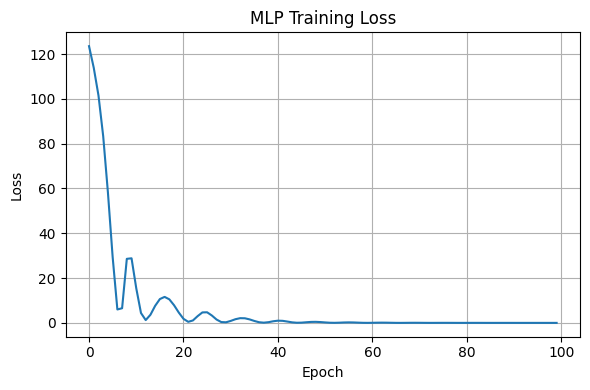


Training GCN...
[MaxCutGCN] Epoch 1, Loss: 101.6311
[MaxCutGCN] Epoch 2, Loss: 100.1351
[MaxCutGCN] Epoch 3, Loss: 98.8573
[MaxCutGCN] Epoch 4, Loss: 97.7530
[MaxCutGCN] Epoch 5, Loss: 96.6312
[MaxCutGCN] Epoch 6, Loss: 95.4080
[MaxCutGCN] Epoch 7, Loss: 93.9988
[MaxCutGCN] Epoch 8, Loss: 92.2545
[MaxCutGCN] Epoch 9, Loss: 90.1631
[MaxCutGCN] Epoch 10, Loss: 87.6658
[MaxCutGCN] Epoch 11, Loss: 84.6982
[MaxCutGCN] Epoch 12, Loss: 81.2233
[MaxCutGCN] Epoch 13, Loss: 77.1841
[MaxCutGCN] Epoch 14, Loss: 72.5987
[MaxCutGCN] Epoch 15, Loss: 67.4879
[MaxCutGCN] Epoch 16, Loss: 61.8805
[MaxCutGCN] Epoch 17, Loss: 55.8316
[MaxCutGCN] Epoch 18, Loss: 49.4531
[MaxCutGCN] Epoch 19, Loss: 42.8925
[MaxCutGCN] Epoch 20, Loss: 36.3826
[MaxCutGCN] Epoch 21, Loss: 30.2715
[MaxCutGCN] Epoch 22, Loss: 24.9608
[MaxCutGCN] Epoch 23, Loss: 20.9247
[MaxCutGCN] Epoch 24, Loss: 18.6509
[MaxCutGCN] Epoch 25, Loss: 18.4851
[MaxCutGCN] Epoch 26, Loss: 20.3340
[MaxCutGCN] Epoch 27, Loss: 23.3654
[MaxCutGCN] Epoch 

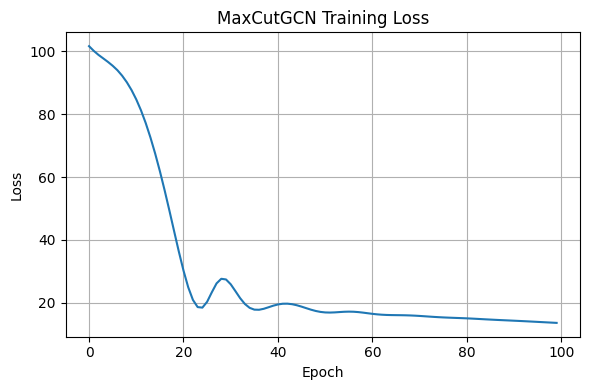


Training GAT...
[MaxCutGAT] Epoch 1, Loss: 100.2919
[MaxCutGAT] Epoch 2, Loss: 98.7741
[MaxCutGAT] Epoch 3, Loss: 97.3340
[MaxCutGAT] Epoch 4, Loss: 96.0073
[MaxCutGAT] Epoch 5, Loss: 94.1651
[MaxCutGAT] Epoch 6, Loss: 91.5908
[MaxCutGAT] Epoch 7, Loss: 89.1555
[MaxCutGAT] Epoch 8, Loss: 84.7208
[MaxCutGAT] Epoch 9, Loss: 79.8436
[MaxCutGAT] Epoch 10, Loss: 76.1003
[MaxCutGAT] Epoch 11, Loss: 68.6837
[MaxCutGAT] Epoch 12, Loss: 61.6843
[MaxCutGAT] Epoch 13, Loss: 52.9416
[MaxCutGAT] Epoch 14, Loss: 43.8351
[MaxCutGAT] Epoch 15, Loss: 39.4238
[MaxCutGAT] Epoch 16, Loss: 35.5417
[MaxCutGAT] Epoch 17, Loss: 21.9487
[MaxCutGAT] Epoch 18, Loss: 21.0810
[MaxCutGAT] Epoch 19, Loss: 32.9728
[MaxCutGAT] Epoch 20, Loss: 23.4860
[MaxCutGAT] Epoch 21, Loss: 36.3593
[MaxCutGAT] Epoch 22, Loss: 34.6210
[MaxCutGAT] Epoch 23, Loss: 27.6981
[MaxCutGAT] Epoch 24, Loss: 24.3421
[MaxCutGAT] Epoch 25, Loss: 21.5506
[MaxCutGAT] Epoch 26, Loss: 19.6448
[MaxCutGAT] Epoch 27, Loss: 19.4883
[MaxCutGAT] Epoch 2

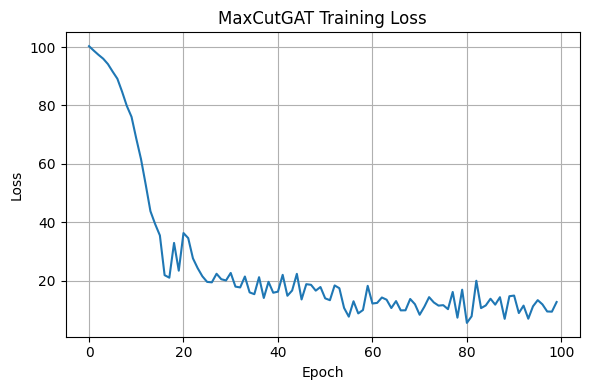


Training GraphSAGE...
[MaxCutGraphSAGE] Epoch 1, Loss: 99.1694
[MaxCutGraphSAGE] Epoch 2, Loss: 97.7566
[MaxCutGraphSAGE] Epoch 3, Loss: 96.4630
[MaxCutGraphSAGE] Epoch 4, Loss: 95.0639
[MaxCutGraphSAGE] Epoch 5, Loss: 93.4128
[MaxCutGraphSAGE] Epoch 6, Loss: 91.3770
[MaxCutGraphSAGE] Epoch 7, Loss: 88.8194
[MaxCutGraphSAGE] Epoch 8, Loss: 85.6577
[MaxCutGraphSAGE] Epoch 9, Loss: 81.8283
[MaxCutGraphSAGE] Epoch 10, Loss: 77.2949
[MaxCutGraphSAGE] Epoch 11, Loss: 72.0060
[MaxCutGraphSAGE] Epoch 12, Loss: 65.9498
[MaxCutGraphSAGE] Epoch 13, Loss: 59.1354
[MaxCutGraphSAGE] Epoch 14, Loss: 51.6788
[MaxCutGraphSAGE] Epoch 15, Loss: 43.8040
[MaxCutGraphSAGE] Epoch 16, Loss: 35.8686
[MaxCutGraphSAGE] Epoch 17, Loss: 28.4570
[MaxCutGraphSAGE] Epoch 18, Loss: 22.3577
[MaxCutGraphSAGE] Epoch 19, Loss: 18.6516
[MaxCutGraphSAGE] Epoch 20, Loss: 18.4095
[MaxCutGraphSAGE] Epoch 21, Loss: 21.5740
[MaxCutGraphSAGE] Epoch 22, Loss: 25.8664
[MaxCutGraphSAGE] Epoch 23, Loss: 28.2926
[MaxCutGraphSAGE] Ep

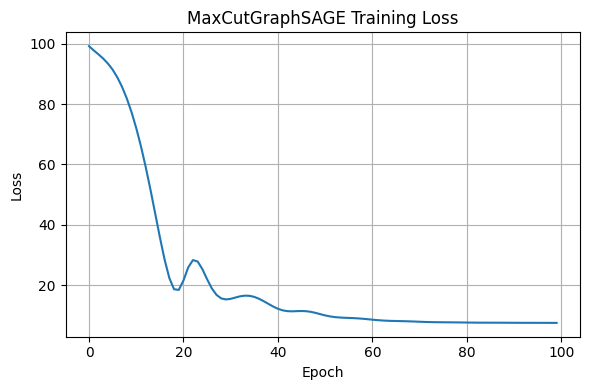


Training GIN...
[MaxCutGIN] Epoch 1, Loss: 101.8249
[MaxCutGIN] Epoch 2, Loss: 98.4127
[MaxCutGIN] Epoch 3, Loss: 93.7346
[MaxCutGIN] Epoch 4, Loss: 86.9391
[MaxCutGIN] Epoch 5, Loss: 76.3237
[MaxCutGIN] Epoch 6, Loss: 60.6161
[MaxCutGIN] Epoch 7, Loss: 39.9926
[MaxCutGIN] Epoch 8, Loss: 17.7856
[MaxCutGIN] Epoch 9, Loss: 8.8932
[MaxCutGIN] Epoch 10, Loss: 32.8019
[MaxCutGIN] Epoch 11, Loss: 29.3898
[MaxCutGIN] Epoch 12, Loss: 15.2563
[MaxCutGIN] Epoch 13, Loss: 8.5004
[MaxCutGIN] Epoch 14, Loss: 9.5735
[MaxCutGIN] Epoch 15, Loss: 13.3508
[MaxCutGIN] Epoch 16, Loss: 16.5263
[MaxCutGIN] Epoch 17, Loss: 17.9034
[MaxCutGIN] Epoch 18, Loss: 17.3408
[MaxCutGIN] Epoch 19, Loss: 15.2259
[MaxCutGIN] Epoch 20, Loss: 12.2933
[MaxCutGIN] Epoch 21, Loss: 9.5782
[MaxCutGIN] Epoch 22, Loss: 8.2540
[MaxCutGIN] Epoch 23, Loss: 9.0173
[MaxCutGIN] Epoch 24, Loss: 11.1496
[MaxCutGIN] Epoch 25, Loss: 12.5876
[MaxCutGIN] Epoch 26, Loss: 11.9801
[MaxCutGIN] Epoch 27, Loss: 10.1005
[MaxCutGIN] Epoch 28, Los

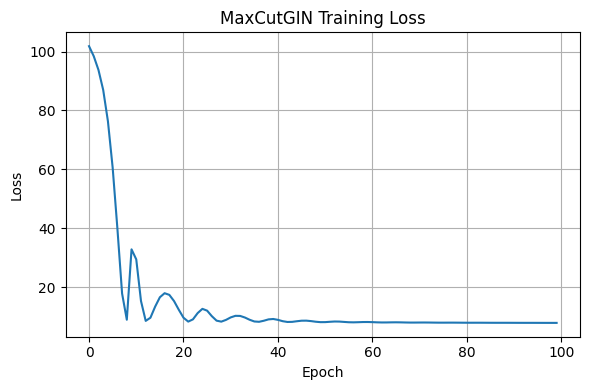

In [11]:
loss_dict = {}
pred_vs_true = {}

# Train MLP
print("\nTraining MLP...")
X_train, y_train, max_len = pad_vectors(vec_train)
X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
mlp = MaxCutMLP(input_size=X_train.shape[1])
preds, true, losses = train_vec(mlp, X_train, y_train, X_test, y_test)
loss_dict["MLP"] = losses
pred_vs_true["MLP"] = (preds, true)

# Train GNNs
for Model, name in [
    (MaxCutGCN, "GCN"),
    (MaxCutGAT, "GAT"),
    (MaxCutGraphSAGE, "GraphSAGE"),
    (MaxCutGIN, "GIN")
]:
    print(f"\nTraining {name}...")
    model = Model(input_dim=pyg_train[0].x.shape[1], hidden_dim=32)
    preds, true, losses = train_gnn(model, pyg_train, pyg_test)
    loss_dict[name] = losses
    pred_vs_true[name] = (preds, true)

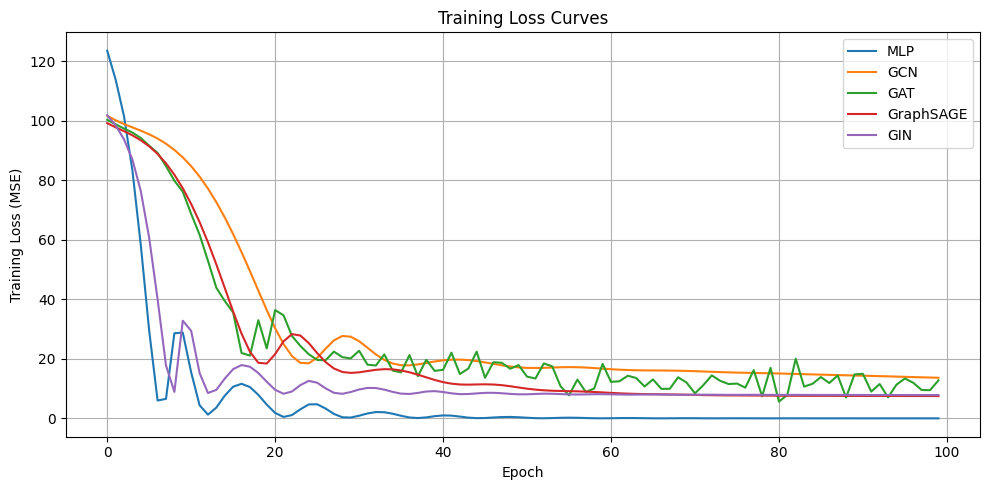

In [12]:
plt.figure(figsize=(10, 5))
for name, losses in loss_dict.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

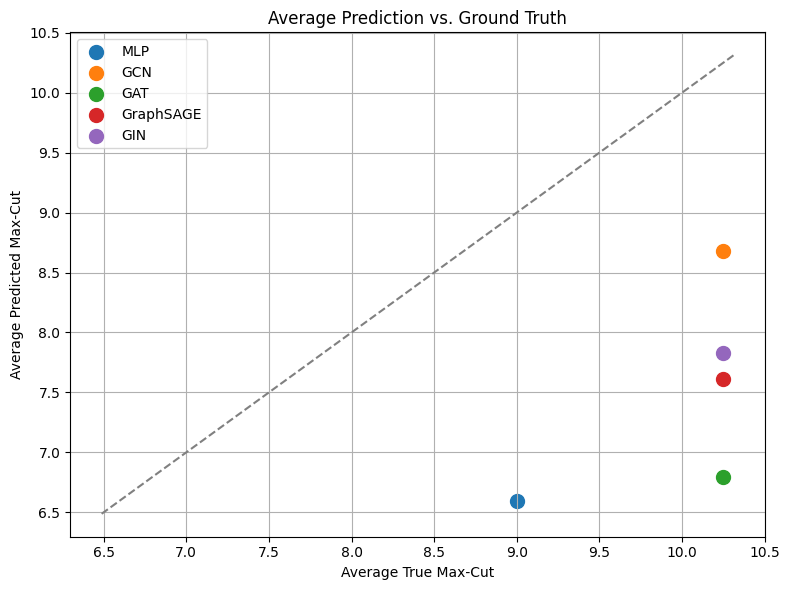

In [13]:
plt.figure(figsize=(8, 6))
for name, (preds, trues) in pred_vs_true.items():
    avg_pred = np.mean(preds)
    avg_true = np.mean(trues)
    plt.scatter(avg_true, avg_pred, label=name, s=100)

# Add identity line
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, linestyle="--", color="gray")

plt.xlabel("Average True Max-Cut")
plt.ylabel("Average Predicted Max-Cut")
plt.title("Average Prediction vs. Ground Truth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()